In [208]:
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer,OneHotEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import joblib
import pickle

In [209]:
df=pd.read_csv('data/data.csv')
df=df.dropna(subset=['SiteEnergyUse(kBtu)'])

def replace_building_type(df):
    df['BuildingType'] = df['BuildingType'].replace({'Nonresidential COS': 'Nonresidential', 'Nonresidential WA': 'Nonresidential'})
    return df


pd.set_option('display.max_columns', None)
df

In [210]:
supprimer= [
    'Address',
    'City',
    'Comments',
    'ComplianceStatus',
    'CouncilDistrictCode',
    'DataYear',
    'DefaultData',
    'Electricity(kBtu)',
    'Electricity(kWh)',
    'ENERGYSTARScore',
    'GHGEmissionsIntensity',
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'Latitude',
    'ListOfAllPropertyUseTypes',
    'Longitude',
    'NaturalGas(kBtu)',
    'NaturalGas(therms)',
    'Neighborhood',
    'OSEBuildingID',
    'Outlier',
    'PropertyGFAParking',
    'PropertyGFATotal',
    'PropertyName',
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'SiteEnergyUseWN(kBtu)',
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'State',
    'SteamUse(kBtu)',
    'TaxParcelIdentificationNumber',
    'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA',
    'TotalGHGEmissions',
    'YearsENERGYSTARCertified',
    'ZipCode', 
    'BuildingType'
]

thresholds = [1.0e6, 2.5e6, 5.0e6, 1.0e7]

In [211]:
df

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7.226362e+06,7.456910e+06,2003882.00,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8.387933e+06,8.664479e+06,0.00,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,7.258702e+07,7.393711e+07,21566554.00,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6.794584e+06,6.946800e+06,2214446.25,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,1.417261e+07,1.465650e+07,0.00,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.00,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.00,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimmin

In [212]:
df.drop(supprimer, axis=1, inplace=True)
df

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),SiteEnergyUse(kBtu)
0,Hotel,1927,1.0,12,88434,7.226362e+06
1,Hotel,1996,1.0,11,88502,8.387933e+06
2,Hotel,1969,1.0,41,759392,7.258702e+07
3,Hotel,1926,1.0,10,61320,6.794584e+06
4,Hotel,1980,1.0,18,113580,1.417261e+07
...,...,...,...,...,...,...
3371,Office,1990,1.0,1,12294,8.497457e+05
3372,Other,2004,1.0,1,16000,9.502762e+05
3373,Other,1974,1.0,1,13157,5.765898e+06
3374,Mixed Use Property,1989,1.0,1,14101,7.194712e+05


In [213]:
categorical_features=['PrimaryPropertyType']
numeric_features=['YearBuilt', 'NumberofBuildings','NumberofFloors', 'PropertyGFABuilding(s)']

In [214]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1)),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# Création du pipeline final
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [215]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFABuilding(s)']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['PrimaryPropertyType'])])),
                ('regressor', LinearRegression())])

In [216]:
# Définir la target et les features après preprocessing
y = df['SiteEnergyUse(kBtu)'].astype(float)
X = df.drop(columns=['SiteEnergyUse(kBtu)'])
X

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s)
0,Hotel,1927,1.0,12,88434
1,Hotel,1996,1.0,11,88502
2,Hotel,1969,1.0,41,759392
3,Hotel,1926,1.0,10,61320
4,Hotel,1980,1.0,18,113580
...,...,...,...,...,...
3371,Office,1990,1.0,1,12294
3372,Other,2004,1.0,1,16000
3373,Other,1974,1.0,1,13157
3374,Mixed Use Property,1989,1.0,1,14101


In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train

,PrimaryPropertyType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s)
547,Small- and Mid-Sized Office,2000,1.0,2,51374
454,Small- and Mid-Sized Office,1900,1.0,6,62176
338,Large Office,2002,1.0,5,353919
26,Hotel,1991,1.0,8,128375
2657,Low-Rise Multifamily,1978,1.0,4,23101
...,...,...,...,...,...
1605,Low-Rise Multifamily,1995,1.0,3,26040
2554,Low-Rise Multifamily,1955,1.0,3,28094
537,Distribution Center,1928,1.0,2,56876
1222,Low-Rise Multifamily,1912,0.0,3,22200


In [218]:
# Entraîner le modèle et prédire
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [219]:
y_pred

array([ 3.78818473e+05,  3.77942255e+06,  8.32413866e+06,  4.22496042e+06,
        2.24416406e+05,  4.21981179e+06,  2.01297112e+06,  5.12507876e+06,
        6.34784314e+06,  7.32321943e+06,  2.24454728e+05,  1.05752058e+06,
        3.84569624e+06,  6.49992378e+06,  3.27322995e+05,  5.15746104e+05,
        9.18628450e+05,  5.29174611e+04,  2.26835247e+06,  1.02493241e+07,
        1.10376124e+07, -6.99597592e+05,  3.61533389e+06,  2.02802954e+06,
        6.71856311e+08,  2.17080133e+05,  1.79793733e+07, -1.31516751e+05,
        3.62635208e+06,  1.21078614e+07,  1.30557581e+06,  3.09431397e+07,
        6.33985293e+06,  2.06808378e+06,  6.47002337e+05,  1.22469022e+05,
        6.94964271e+06,  5.76007216e+05,  1.72745451e+05,  6.63550485e+06,
        1.33902630e+06,  1.96676329e+07,  4.36253033e+04,  4.48711006e+05,
        1.17999134e+07, -1.05133465e+05,  2.19871071e+05,  2.55688946e+05,
        1.68046440e+06,  4.65785644e+05,  8.91051223e+05, -6.37245773e+05,
        3.74667113e+06,  

In [220]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Entraîner le modèle et prédire
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculer le coefficient de détermination R^2
r2 = r2_score(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)

print(f"Coefficient de détermination R^2 : {r2:.4f}")
print(f"MAE : {mae:.4f}")
model_path = 'trained_model.pkl'

# Exportation du modèle avec pickle
with open(model_path, 'wb') as f:
    pickle.dump(pipeline, f)

print(f"Modèle exporté avec succès dans : {model_path}")

Coefficient de détermination R^2 : 0.9113
MAE : 2846491.2434
Modèle exporté avec succès dans : trained_model.pkl


In [205]:

# Utiliser un modèle de forêt aléatoire pour la sélection des caractéristiques
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Utiliser SelectFromModel pour sélectionner les caractéristiques importantes
selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X)

# Vérifier les caractéristiques sélectionnées
selected_features = poly_features.columns[selector.get_support()]
print(selected_features)

ValueError: could not convert string to float: 'Hotel'

In [206]:
# Models to test
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet()
}

# Parameter grids for hyperparameter tuning
param_grids = {
    'Ridge': {
        'regressor__alpha': [0.1, 1.0, 10.0]  # Example values for alpha
    },
    'Lasso': {
        'regressor__alpha': [0.1, 1.0, 10.0]  # Example values for alpha
    },
    'ElasticNet': {
        'regressor__alpha': [0.1, 1.0, 10.0],  # Example values for alpha
        'regressor__l1_ratio': [0.25, 0.5, 0.75]  # Example values for l1_ratio
    }
}

# Create an empty dictionary to store results
results = {}

# Iterate over models
for model_name, model in models.items():
    # Update the regressor in the pipeline
    pipeline.steps[-1] = ('regressor', model)

    # Grid search for hyperparameter optimization
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    # Store results
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_score': grid_search.score(X_test, y_test)
    }

# Print results
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best cross-validation score: {result['best_score']:.4f}")
    print(f"Test score: {result['test_score']:.4f}")
    print(f"Best parameters: {result['best_params']}")
    print()

/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1392491420922592.0, tolerance: 35253797241896.33
  model = cd_fast.sparse_enet_coordinate_descent(
/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1373387011715456.0, tolerance: 65294705308301.85
  model = cd_fast.sparse_enet_coordinate_descent(
/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4982530432254752.0, tolerance: 62812014739963.33
  model = cd_fast.sparse_enet_coordinate_descent

Model: Ridge
Best cross-validation score: 0.5989
Test score: 0.9120
Best parameters: {'regressor__alpha': 0.1}

Model: Lasso
Best cross-validation score: 0.5987
Test score: 0.9113
Best parameters: {'regressor__alpha': 10.0}

Model: ElasticNet
Best cross-validation score: 0.4823
Test score: 0.9288
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.75}



In [207]:
# Modèles à tester
models = {
    'XGBoost': xgb.XGBRegressor()
}

# Grilles de paramètres pour le réglage des hyperparamètres
param_grids = {
    'XGBoost': {
        'regressor__learning_rate': [0.1, 0.01],  # Taux d'apprentissage
        'regressor__max_depth': [3, 5, 7],  # Profondeur maximale de l'arbre
        'regressor__min_child_weight': [1, 3, 5],  # Poids minimal des enfants
        'regressor__subsample': [0.8, 1.0],  # Sous-échantillonnage des observations
        'regressor__colsample_bytree': [0.8, 1.0]  # Sous-échantillonnage des colonnes
    }
}
# Exemple de pipeline avec standardisation et modèle XGBoost
pipeline = Pipeline(steps=[
    ('preprocessor', StandardScaler()),  # Standardisation des caractéristiques si nécessaire
    ('regressor', xgb.XGBRegressor())  # Modèle XGBoost
])
# Dictionnaire pour stocker les résultats
results = {}

# Itérer sur les modèles
for model_name, model in models.items():
    # Mise à jour du modèle dans le pipeline
    pipeline.steps[-1] = ('regressor', model)

    # Recherche de grille pour l'optimisation des hyperparamètres
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    # Stocker les résultats
    results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_score': grid_search.score(X_test, y_test)
    }

# Afficher les résultats
for model_name, result in results.items():
    print(f"Modèle: {model_name}")
    print(f"Meilleur score de validation croisée: {result['best_score']:.4f}")
    print(f"Score sur le test: {result['test_score']:.4f}")
    print(f"Meilleurs paramètres: {result['best_params']}")
    print()


ValueError: 
All the 360 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 839, in fit
    return self.partial_fit(X, y, sample_weight)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_data.py", line 875, in partial_fit
    X = self._validate_data(
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 605, in _validate_data
    out = check_array(X, input_name="X", **check_params)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/ndaoalassane/.pyenv/versions/lewagon/lib/python3.10/site-packages/pandas/core/generic.py", line 2070, in __array__
    return np.asarray(self._values, dtype=dtype)
ValueError: could not convert string to float: 'Small- and Mid-Sized Office'


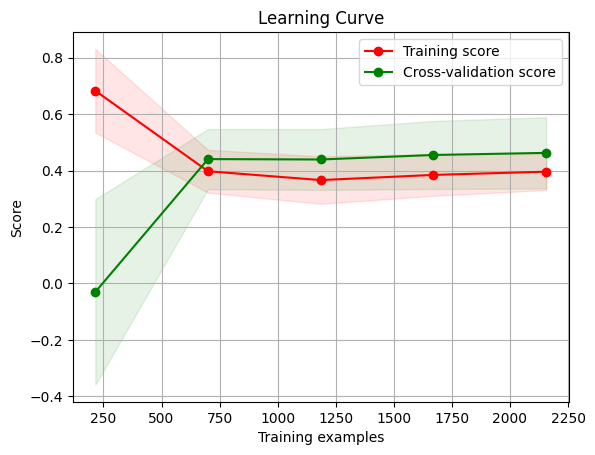

In [50]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Example usage
plot_learning_curve(pipeline, "Learning Curve", X_train, y_train, cv=5)
plt.show()

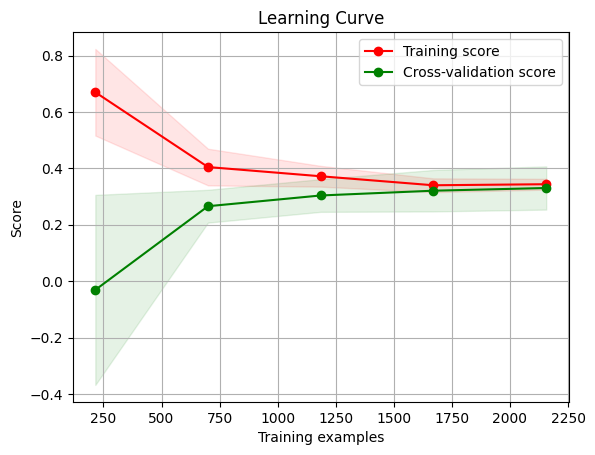

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Shift the values to handle zero or negative values
    y_shifted = y - np.min(y) + 1e-10
    y_log = np.log1p(y_shifted)

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y_log, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Example usage
plot_learning_curve(pipeline, "Learning Curve", X_train, y_train, cv=5)
plt.show()


In [51]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SGDRegressor(penalty='elasticnet', random_state=2))
])

# Définition de la grille des hyperparamètres à rechercher
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0],
    'regressor__l1_ratio': [0.25, 0.5, 0.75],
    'regressor__max_iter': [1000, 2000],
    'regressor__tol': [1e-3, 1e-4]
}

# Division des données en train/test

# Recherche des meilleurs paramètres avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Meilleur modèle après la recherche
best_model = grid_search.best_estimator_

# Évaluation sur le jeu de test
y_pred = best_model.predict(X_test)
test_score = r2_score(y_test, y_pred)

print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
print(f"Test score: {test_score:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

Best cross-validation score: 0.4936
Test score: 0.8837
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.75, 'regressor__max_iter': 1000, 'regressor__tol': 0.001}


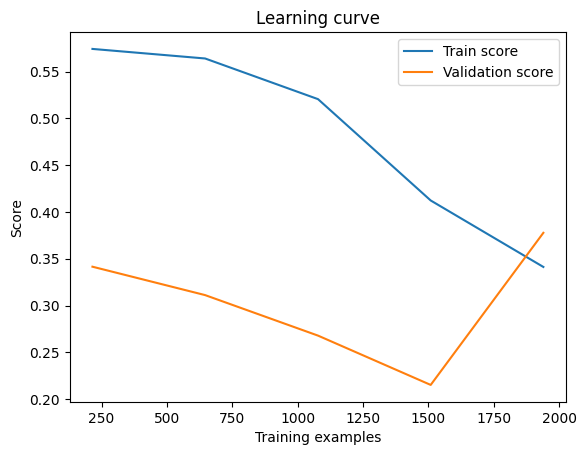

In [15]:

train_sizes, train_scores, valid_scores = learning_curve(
    best_model, X_train, y_train, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9], cv=5
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train score')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que vos données sont chargées dans un DataFrame df
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_features])
# Appliquer t-SNE pour réduire les données à 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Créer un DataFrame pour les résultats t-SNE
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Générer des données d'exemple
np.random.seed(0)
X = np.random.rand(100, 5)
y = np.random.rand(100) * 1000  # Cible aléatoire non négative

# Transformation logarithmique de la cible
y_log = np.log1p(y)

# Définir les paramètres du modèle XGBoost
params = {
    'objective': 'reg:squarederror',  # Régression pour les valeurs continues
    'eval_metric': 'rmse',  # Métrique d'évaluation : RMSE (Root Mean Squared Error)
    'max_depth': 3,  # Profondeur maximale de l'arbre
    'eta': 0.1,  # Taux d'apprentissage
    'subsample': 0.8,  # Fraction d'échantillons utilisés pour entraîner chaque arbre
    'colsample_bytree': 0.8  # Fraction de caractéristiques utilisées pour entraîner chaque arbre
}

# Nombre d'itérations pour XGBoost
num_boost_round = 100

# Nombre de folds pour la validation croisée
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Liste pour stocker les scores RMSE sur les folds
cv_scores = []

# Boucle sur les folds de la validation croisée
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_log[train_index], y_log[val_index]

    # Créer un objet DMatrix pour XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Entraîner le modèle XGBoost
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round, evals=[(dval, 'eval')], verbose_eval=False)

    # Prédire sur les données de validation
    y_pred = model.predict(dval)

    # Calculer le RMSE sur ce fold
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    cv_scores.append(rmse)

# Afficher les scores RMSE pour chaque fold
print(f"CV Mean RMSE: {np.mean(cv_scores):.4f}, Std RMSE: {np.std(cv_scores):.4f}")

# Tracer l'importance des caractéristiques si nécessaire
# xgb.plot_importance(model)
# plt.show()


CV Mean RMSE: 1.4139, Std RMSE: 0.3731
